# LEAFX
   >A project on leaf hole detection and counting by **Arvin Mangahis** and **Don Minaga**

In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Helper Functions

In [6]:
def show_image(img, title=''):
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.xticks([]), plt.yticks([])
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.title(title)
    plt.imshow(pixels)
    plt.show()

In [5]:
def show_sidebyside(img1, img2):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    pixels1 = np.array(image1)
    plt.imshow(pixels1)
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.title('Original')
    plt.xticks([]), plt.yticks([])
    
    f.add_subplot(1, 2, 2)
    image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    pixels2 = np.array(image2)
    plt.imshow(pixels2)
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.title('Result')
    plt.xticks([]), plt.yticks([])
    plt.show(block=True)

In [14]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    start = time.time()
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    end = time.time()
    print("Resize time = ", end - start, 'ms')
    return resized

   > Image masking and foreground and background extraction

In [15]:
def mask_image(img_path, iteration=5):
    start = time.time()
    
    # Read and store image
    img = cv2.imread(img_path)
    
    # Resize image if pixel over 1000 for faster runtime
    if int(np.size(img, 1)) > 1000:
        img = image_resize(img, width = 1000)
    
    # Image thresholding and contour finding using GaussianBlur
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(imgray, (5, 5), 0)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Creating the list of areas of contours
    areaArray = []
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        areaArray.append(area)

    # Sorting by area
    sortcontours = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

    # nth largest contour [n-1][1]
    secondlargestcontour = sortcontours[0][1]
    
    # Draw
    #cv2.drawContours(img, secondlargestcontour, -1, (0, 0, 255), 2)
    x, y, w, h = cv2.boundingRect(secondlargestcontour)
    rect = (x, y, w-5, h-5)
    
    # Asigning foreground and background models
    mask = np.zeros(img.shape[:2],np.uint8)
    fgdModel = np.zeros((1,65),np.float64)
    bgdModel = np.zeros((1,65),np.float64)
    
    # Grabcut function w/ 5 iteration
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iteration, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    final = img*mask2[:, :, np.newaxis]
    
    show_sidebyside(img, final)
    
    #print("Original image size = ", os.stat(img_path).st_size, 'bytes')
    
    end = time.time()
    print("Masking time = ", end - start, 'ms')
    cv2.imwrite('save.png',final)
    return (img, final)

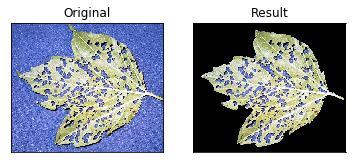

In [9]:
x = mask_image('leafs/dest.jpg')

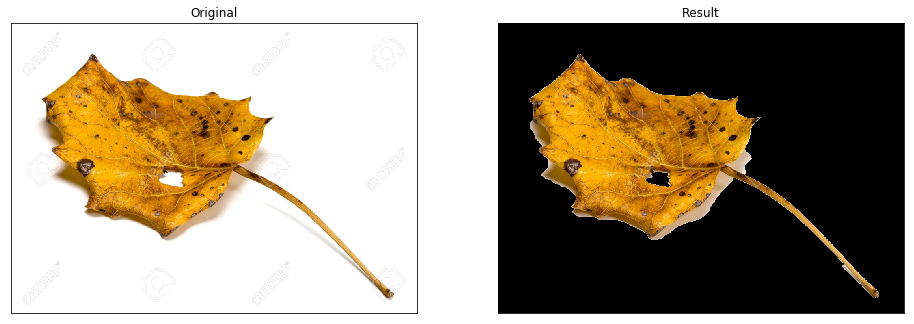

In [10]:
_ = mask_image('leafs/x.jpg', 12)

   > Adaptive thresholding and contour segmentation

In [55]:
def count_holes(img_path, o):
    start = time.time()
    
    # Read Image
    img = img_path
    
    # Duplicate Image
    orig_img = img.copy()
    
    # Convert Image to Grayscale
    img_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    
    show_image(img_gray, 'Grayscale')
    
    # Binarize image(Thresholding), various options.
    #thresh, img_bw = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh, img_bw = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #thresh, img_bw = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #thresh, img_bw = cv2.threshold(img_gray, 127 , 255, 0)
    #blur = cv2.GaussianBlur(img_gray,(5,5),0)
    #thresh, img_bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    show_image(img_bw, 'Binarized')
    
    # Find all contours
    contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Store each contour area in a dictionary with its corresponding index as the key
    dict = {n : cv2.contourArea(contours[n]) for n in range(len(contours))}
    
    # Sort list by value
    sorted_by_value = sorted(dict.items(), key=lambda kv: kv[1], reverse=True)
    
    # Not used.
    # Store edges to a list while ignoring first two elements since we only want the area of the leaf
    c = []
    for e in range(2, len(sorted_by_value)):
        c.append(contours[sorted_by_value[e][0]])
    # end of not used
    print(hierarchy)
    print(sorted_by_value)
    # Critical section (?)
    l = [(i, v)  for i, v in enumerate(hierarchy[0]) if v[3] == sorted_by_value[0][0]]

    _ = []
    for n in l:
        if cv2.contourArea(contours[n[0]]) > 8:
            _.append(contours[n[0]])
    
    # Duplicate original image for results and comparison
    result_img = o.copy()
    
    # Draw all the contours on the duplicated image
    #cnt = np.array(c)
    cnt = _
    cv2.drawContours(result_img, cnt if len(cnt) > 1 else [cnt], -1, (0, 0, 255), 2)
    
    # Result
    show_sidebyside(o, result_img)
    print("Suspected ", len(cnt), " holes" if len(cnt) > 1 else " hole")
    
    #print("Image size = ", os.stat(img_path).st_size, 'bytes')
    #print("IMG TYPE", type(result_img))
    end = time.time()
    print("Counting time = ", end - start, 'ms')
    return len(cnt)

In [17]:
def leafx(img_path, iteration=5):
    start = time.time()
    
    res = mask_image(img_path, iteration)
    
    count = count_holes(res[1], res[0])
    
    end = time.time()
    print("Total Execution time = ", end - start, 'ms')
    
    return count

# Notes for optimization
   > Using ML to detect leaves even on complicated backgrounds
   

# Test Cases

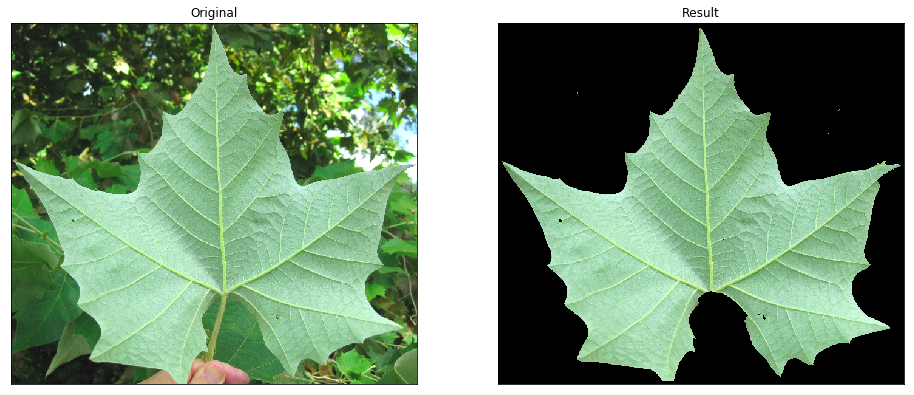

Masking time =  7.778169870376587 ms


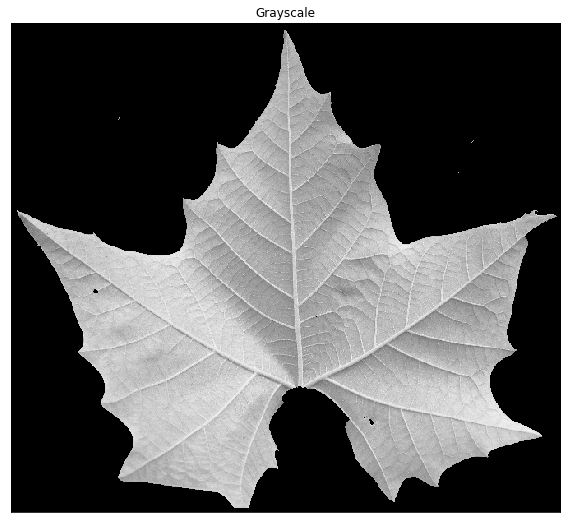

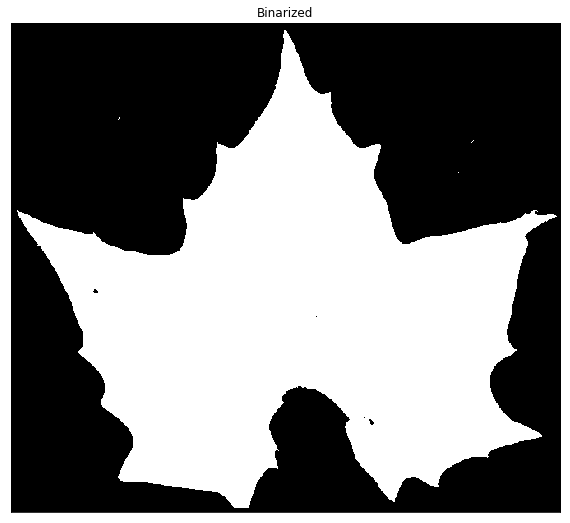

[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [-1  2  4 -1]
  [ 5 -1 -1  3]
  [ 6  4 -1  3]
  [ 7  5 -1  3]
  [-1  6 -1  3]]]
[(3, 174606.5), (7, 31.0), (4, 29.0), (5, 4.0), (6, 2.0), (0, 0.0), (1, 0.0), (2, 0.0)]


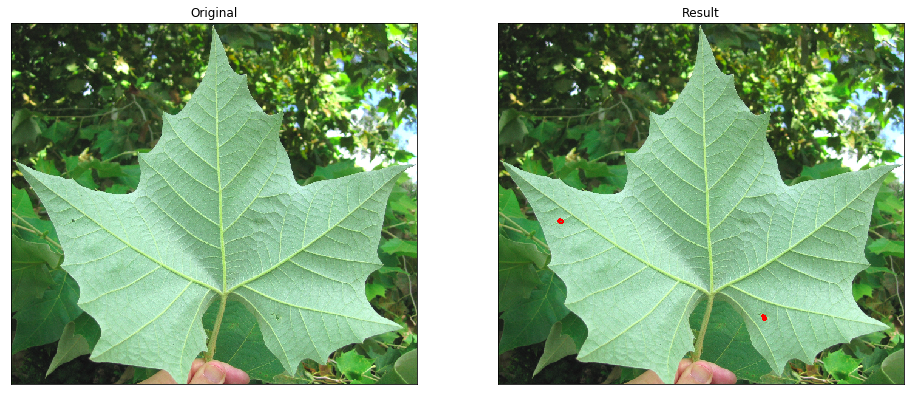

Suspected  2  holes
Counting time =  1.433485746383667 ms
Total Execution time =  9.230075359344482 ms


2

In [58]:
leafx('T.png', 12)

Resize time =  0.01611924171447754 ms


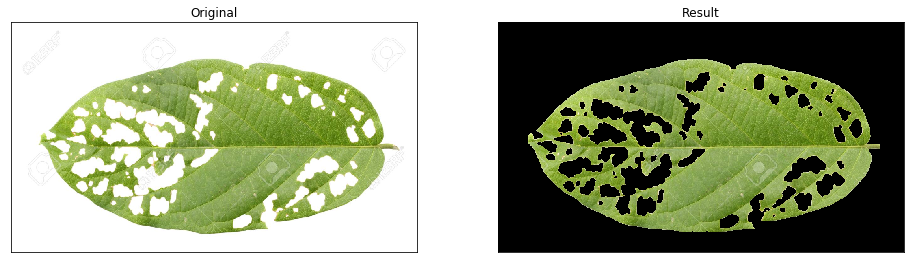

Masking time =  3.6894869804382324 ms


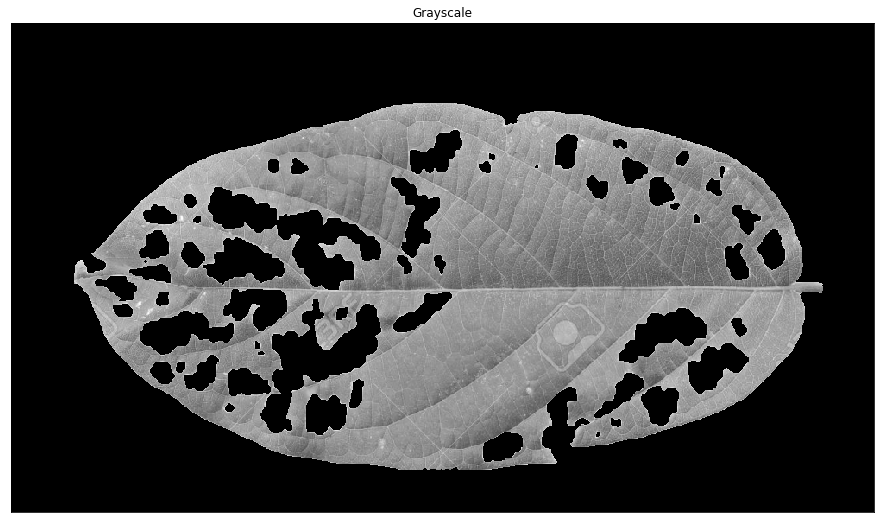

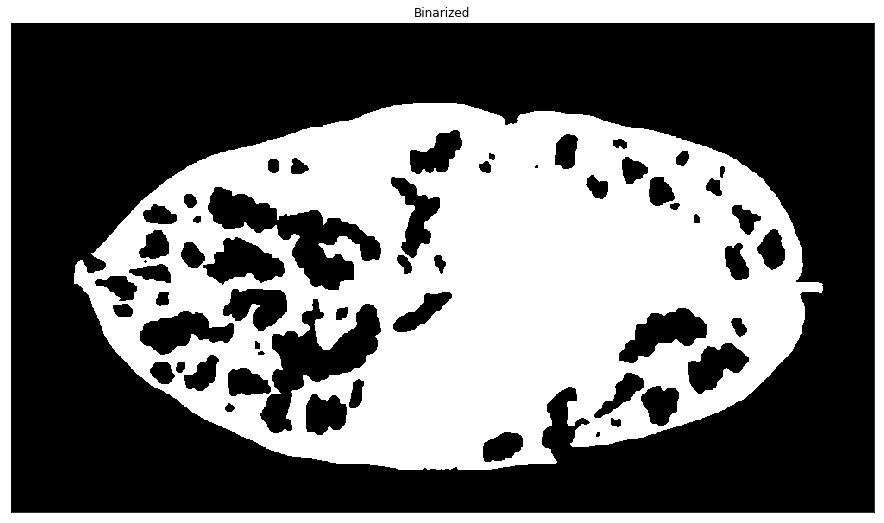

[[[-1 -1  1 -1]
  [ 2 -1 -1  0]
  [ 3  1 -1  0]
  [ 4  2 -1  0]
  [ 5  3 -1  0]
  [ 6  4 -1  0]
  [ 7  5 -1  0]
  [ 8  6 -1  0]
  [ 9  7 -1  0]
  [10  8 -1  0]
  [11  9 -1  0]
  [12 10 -1  0]
  [13 11 -1  0]
  [14 12 -1  0]
  [15 13 -1  0]
  [16 14 -1  0]
  [17 15 -1  0]
  [18 16 -1  0]
  [19 17 -1  0]
  [20 18 -1  0]
  [21 19 -1  0]
  [22 20 -1  0]
  [23 21 -1  0]
  [24 22 -1  0]
  [25 23 -1  0]
  [26 24 -1  0]
  [27 25 -1  0]
  [28 26 -1  0]
  [29 27 -1  0]
  [30 28 -1  0]
  [31 29 -1  0]
  [32 30 -1  0]
  [33 31 -1  0]
  [34 32 -1  0]
  [35 33 -1  0]
  [36 34 -1  0]
  [37 35 -1  0]
  [38 36 -1  0]
  [39 37 -1  0]
  [40 38 -1  0]
  [41 39 -1  0]
  [42 40 -1  0]
  [43 41 -1  0]
  [44 42 -1  0]
  [45 43 -1  0]
  [46 44 -1  0]
  [47 45 -1  0]
  [48 46 -1  0]
  [49 47 -1  0]
  [50 48 -1  0]
  [51 49 -1  0]
  [52 50 -1  0]
  [53 51 -1  0]
  [54 52 -1  0]
  [55 53 -1  0]
  [56 54 -1  0]
  [-1 55 -1  0]]]
[(0, 272340.5), (41, 8795.5), (21, 8351.0), (18, 3463.0), (17, 3229.5), (32, 3164.5), 

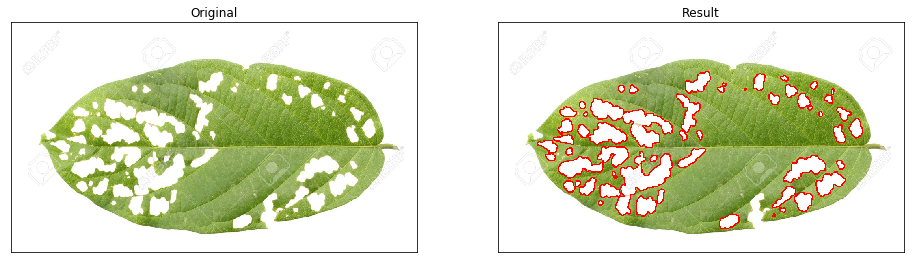

Suspected  56  holes
Counting time =  1.4446220397949219 ms
Total Execution time =  5.178082704544067 ms


56

In [57]:
leafx('leafs/eaten.jpg')

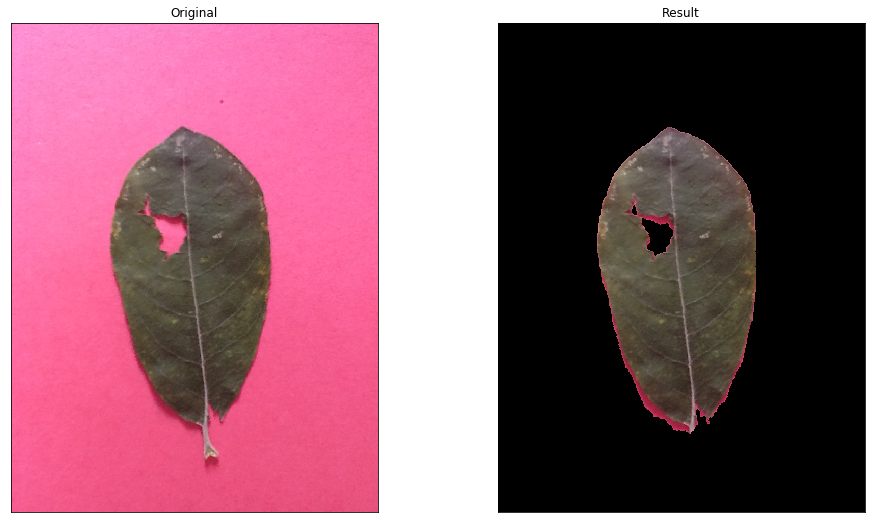

Masking time =  6.241491317749023 ms


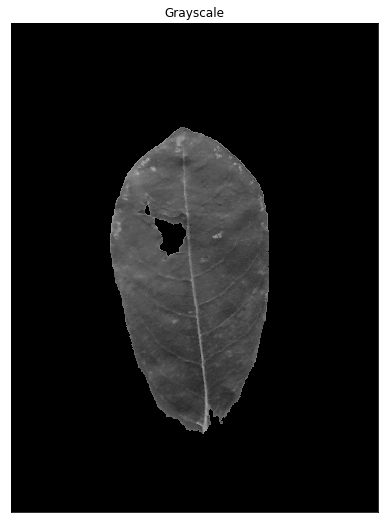

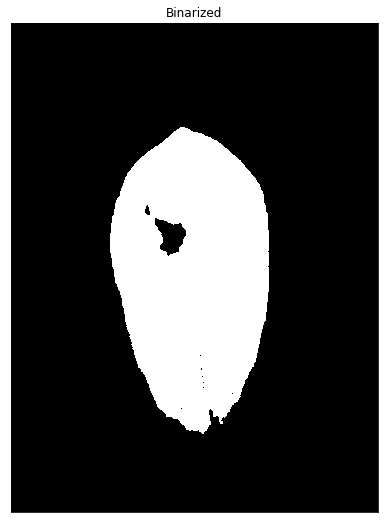

[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [-1  1  3 -1]
  [ 4 -1 -1  2]
  [ 5  3 -1  2]
  [ 6  4 -1  2]
  [ 7  5 -1  2]
  [ 8  6 -1  2]
  [ 9  7 -1  2]
  [10  8 -1  2]
  [11  9 -1  2]
  [12 10 -1  2]
  [13 11 -1  2]
  [14 12 -1  2]
  [15 13 -1  2]
  [16 14 -1  2]
  [17 15 -1  2]
  [18 16 -1  2]
  [19 17 -1  2]
  [-1 18 -1  2]]]
[(2, 138538.0), (18, 2778.5), (19, 154.5), (13, 8.0), (3, 4.0), (6, 4.0), (7, 4.0), (10, 4.0), (14, 4.0), (15, 4.0), (16, 4.0), (4, 2.0), (5, 2.0), (8, 2.0), (9, 2.0), (11, 2.0), (12, 2.0), (17, 2.0), (0, 0.0), (1, 0.0)]


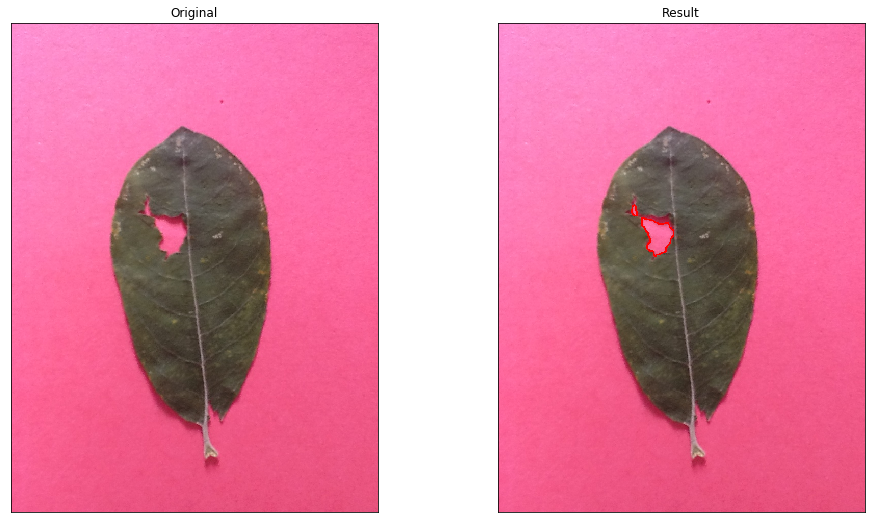

Suspected  2  holes
Counting time =  1.4343926906585693 ms
Total Execution time =  7.695106029510498 ms


2

In [56]:
leafx('leaf_dataset/RGB/2. Salix atrocinerea/iPAD2_C02_EX10.JPG', 12)

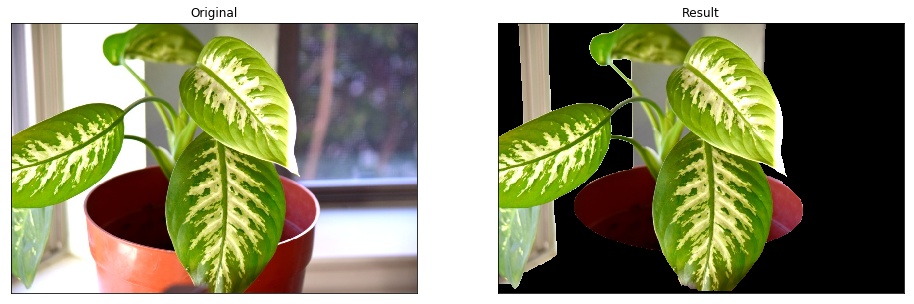

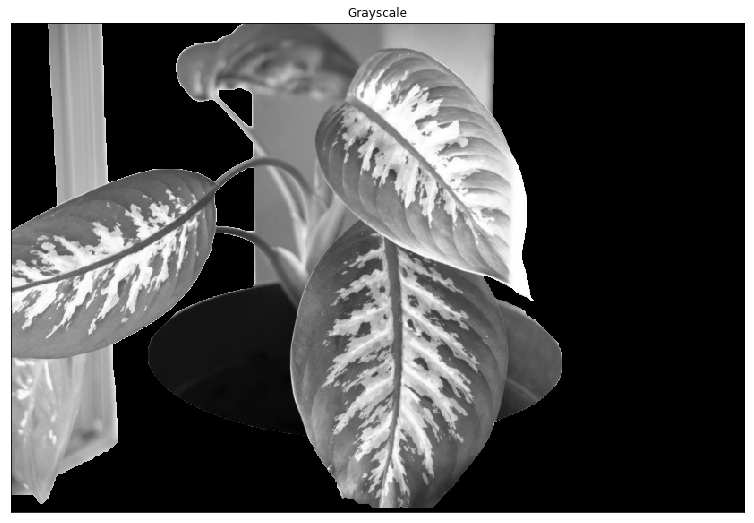

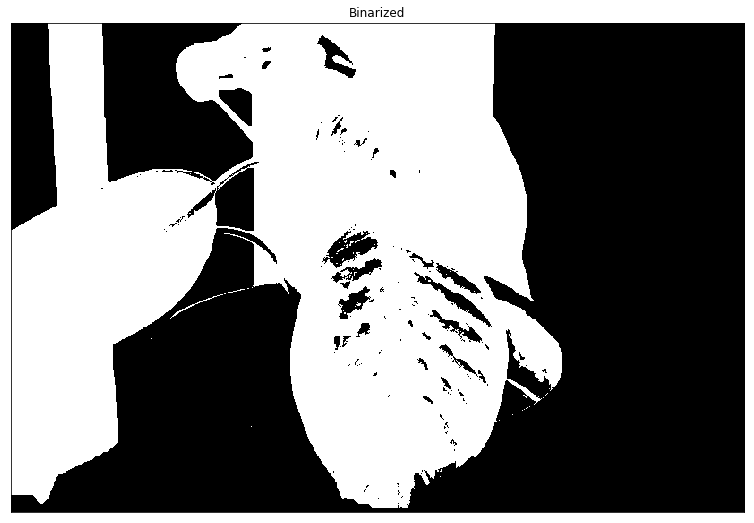

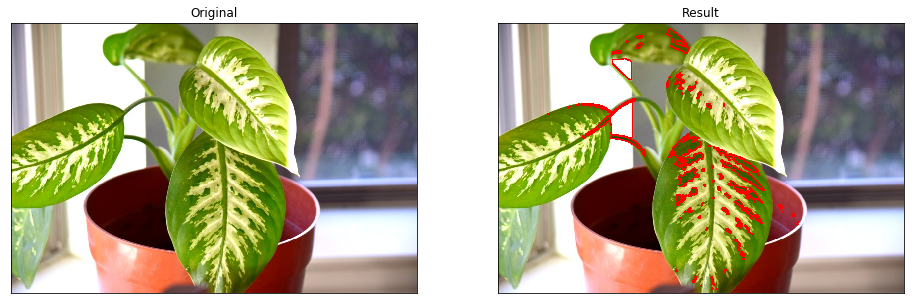

Suspected  246  holes
IMG TYPE <class 'numpy.ndarray'>
Execution time =  27.212621688842773 ms


246

In [13]:
leafx('leafs/indoor.jpg', 32)